JPEG is probably one of the most common compression algorithms at all. Today we will describe, how it works and use Python to put our hands on the low-level compression steps and work with the DCT coefficients.

## JPEG format

TODO: JPEG compression

TODO: JPEG format

## JPEG in Python

Loading decompressed file in Python is a very common task, implemented in many popular image processing libraries. The two most common approaches according to StackOverflow are with **pillow** and **matplotlib** libraries.

Pillow is a fork of PIL (Python Imaging Library). It has a very simple interface, encapsulating automatic choice of the codec for various image formats.

In [2]:
from PIL import Image
im = Image.open("img/IMG_0791.jpeg")
print(type(im), im.format, im.size, im.mode)

<class 'PIL.JpegImagePlugin.JpegImageFile'> JPEG (4032, 3024) RGB


To convert the PIL image object to numpy array of pixels, use *numpy.asarray* function.

In [3]:
import numpy as np
data = np.asarray(im)
print(type(data), data.shape)

<class 'numpy.ndarray'> (3024, 4032, 3)


In [5]:
#im.quantization

The pixel values are in domain between 0 and 256.

In [6]:
data.min(), data.max()

(0, 255)

The second named option is a function *imread* from matplotlib library. The returned object is already stored as a numpy array.

In [9]:
from matplotlib import image
data2 = image.imread("img/IMG_0791.jpeg")
type(data2)

numpy.ndarray

The pixel values are again between 0 and 256.

In [10]:
data2.min(), data2.max()

(0, 255)

The decompression of both libraries results in the identical spatial (RGB) representation.

In [11]:
(data == data2).all()

True

For steganography, we are interested in loading of the raw DCT coefficients of the file. This was surprisingly more time consuming task to find an easy way than I thought. After a few hours of active searching, the best solution that I found for reading JPEG DCT coefficients to Python is using a *torchjpeg*. To do so, use *torchjpeg.codec.read_coefficients* function.

In [13]:
import torchjpeg.codec
shape,qt,Y,CbCr = torchjpeg.codec.read_coefficients("img/IMG_0791.jpeg")

The function returns tuple of four items:

* shape
* quantization table
* tensor of DCT of the luminance (luma) component 
* tensor of DCT of the chrominance (chroma) components

### Channel dimension

In [14]:
shape.shape

torch.Size([3, 2])

In [15]:
shape

tensor([[3024, 4032],
        [1512, 2016],
        [1512, 2016]], dtype=torch.int32)

The first returned object (of dimensions Cx2) is a shape of color channels. The example jpeg has both chroma channels of half sample rate along both height and width compared to the luma channel, i.e. subsampling 4:2:2.

### Quantization table

In [16]:
qt.shape

torch.Size([3, 8, 8])

In [17]:
qt

tensor([[[ 2,  2,  2,  3,  5,  6,  8, 10],
         [ 2,  2,  2,  3,  5,  6,  8, 10],
         [ 2,  2,  3,  5,  6,  8, 10, 12],
         [ 3,  3,  5,  6,  8, 10, 12, 14],
         [ 5,  5,  6,  8, 10, 12, 14, 15],
         [ 6,  6,  8, 10, 12, 14, 15, 15],
         [ 8,  8, 10, 12, 14, 15, 15, 15],
         [10, 10, 12, 14, 15, 15, 15, 15]],

        [[ 2,  2,  4,  7, 16, 16, 16, 16],
         [ 2,  4,  4, 11, 16, 16, 16, 16],
         [ 4,  4,  9, 16, 16, 16, 16, 16],
         [ 7, 11, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16]],

        [[ 2,  2,  4,  7, 16, 16, 16, 16],
         [ 2,  4,  4, 11, 16, 16, 16, 16],
         [ 4,  4,  9, 16, 16, 16, 16, 16],
         [ 7, 11, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
         [16, 16, 16, 16, 16, 16, 16, 16],
       

The second are the quantization tables (Cx8x8) for all the color channels. Each channel can define its own quantization table, chroma channels in the example jpeg have equal quantization table.

Luma channel undergoes lower compression than the chroma channels, because its values in the quantization table are lower.

### DCT coefficients

For jpeg, the DCT coefficients are stored in 8x8 blocks. Thus the sizes of the tensor where they are stored should have dimensions divided by 8 compared to the full shape of the image.

#### Luminance

Luma channel DCT coefficients is returned as the third value.

In [18]:
Y.shape

torch.Size([1, 378, 504, 8, 8])

In [19]:
Y

tensor([[[[[ 384,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           ...,
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0]],

          [[ 384,    0,   -2,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           [  -2,    0,    1,  ...,    0,    0,    0],
           ...,
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0]],

          [[ 385,   -2,   -1,  ...,    0,    0,    0],
           [   1,   -1,   -1,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           ...,
           [   0,    0,    0,  ...,    0,    0,    0],
           [   0,    0,    0,  ...,    0,    0,    0],
           [ 

The dimension of the channel is given by 8x8 blocks, fitted into the channel shape. The number of blocks that forms the luma channel is

In [20]:
import torch
torch.prod(shape[0] / 8)

tensor(190512.)

The shape of the luma channel is 1 x W/2 x H/2 x 8 x 8.

#### Chrominance

Fourth value is the chroma channels, also in 8x8 blocks.

In [21]:
CbCr.shape

torch.Size([2, 189, 252, 8, 8])

The first dimension is 2, because there are two chroma channels. The second and the third dimension differs from the luma channel due to the subsampling mentioned before. Blocks have the same size. The number of blocks for each of the chroma channel is

In [16]:
torch.prod(shape[1] / 8)

tensor(47628.)

Proceed from DCT to spatial representation using following call

In [22]:
data3 = torchjpeg.codec.reconstruct_full_image(Y, qt, CbCr, shape)

In [23]:
data3.shape

torch.Size([3, 3024, 4032])

In [24]:
data.shape

(3024, 4032, 3)

In [25]:
from torchvision.transforms.functional import to_pil_image
data3np = np.asarray(to_pil_image(data3))

In [21]:
def replaceColor(x,D=None):
    if D is None:
        D = x
    x[D > 0] = np.array([0,0,0])
    x[D == 0] = np.array([0,0,0])
    x[D < 0] = np.array([0,1,0])
    return x

# make difference
Ddata = (data - data3np).astype(np.int8)
# separate channels
DdataR = replaceColor(Ddata.copy(), Ddata[:,:,0])
DdataG = replaceColor(Ddata.copy(), Ddata[:,:,1])
DdataB = replaceColor(Ddata.copy(), Ddata[:,:,2])

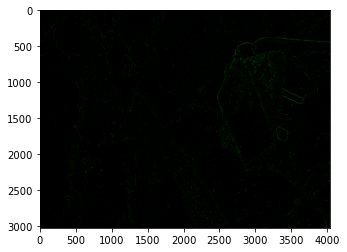

In [22]:
import matplotlib.pyplot as plt
plt.imshow(DdataG.astype(np.float))

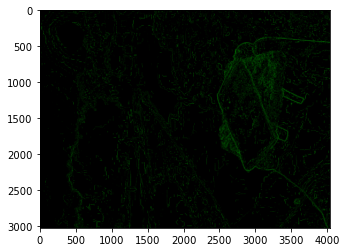

In [23]:
plt.imshow(DdataR.astype(np.float))

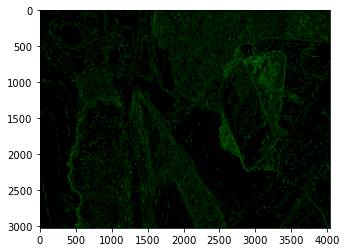

In [24]:
plt.imshow(DdataB.astype(np.float))

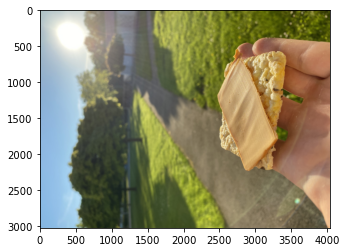

In [25]:
plt.imshow(data)

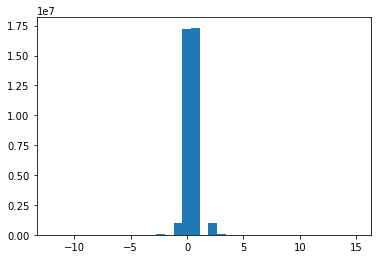

In [26]:
import matplotlib.pyplot as plt
plt.hist((data - data3np).astype(np.int8).flatten(), bins=35);

In [27]:
datatorch = torch.tensor(im)

RuntimeError: Could not infer dtype of JpegImageFile

In [ ]:
data3

In [ ]:
ycbcr_rgb = np.array([
    [.299, .587, .114],
    [-.16874, -.33126, .5],
    [.5,-.41869,-.08131]
])

In [ ]:
rgb_ycbcr = np.linalg.inv(ycbcr_rgb)
rgb_ycbcr

In [ ]:
ycbcr_rgb @ rgb_ycbcr

In [ ]:
def my_to_rgb(x):
    # fmt: off
    rgb_from_ycbcr_np = np.linalg.inv(np.array([
        [.299, .587, .114],
        [-.16874, -.33126, .5],
        [.5,-.41869,-.08131]
    ])).astype(np.float32)
    rgb_from_ycbcr = torch.from_numpy(rgb_from_ycbcr_np).view(3,3).transpose(0,1)
    #rgb_from_ycbcr = torch.tensor([
    #    1, 0, 1.40200,
    #    1, -0.344136286, -0.714136286,
    #    1, 1.77200, 0
    #]).view(3, 3).transpose(0, 1)
    # fmt: on
    b = torch.tensor([-179.456, 135.458816, -226.816]).view(3, 1, 1)
    x = torch.einsum("cv,...cxy->...vxy", [rgb_from_ycbcr, x])
    x += b

    return x.contiguous()

from torch.nn.functional import interpolate
def my_reconstruct(y_coefficients, quantization, cbcr_coefficients, crop):
    y = torchjpeg.codec.pixels_for_channel(y_coefficients, quantization[0], crop[0] if crop is not None else None)
    cb = torchjpeg.codec.pixels_for_channel(cbcr_coefficients[0:1], quantization[1], crop[1] if crop is not None else None)
    cr = torchjpeg.codec.pixels_for_channel(cbcr_coefficients[1:2], quantization[2], crop[2] if crop is not None else None)

    cb = interpolate(cb.unsqueeze(0).unsqueeze(0), y.shape, mode="nearest")
    cr = interpolate(cr.unsqueeze(0).unsqueeze(0), y.shape, mode="nearest")

    out = torch.cat([y.unsqueeze(0).unsqueeze(0), cb, cr], dim=1)
    out = my_to_rgb(out).squeeze()
    out = out.clamp(0, 255) / 255.0
    return out

In [ ]:
data3my = my_reconstruct(Y, qt, CbCr, shape)
(data3np - np.asarray(to_pil_image(data3))).astype(np.int8)

## References

* Jessica Fridrich: Steganography in digital media. DOI: <a href="https://doi.org/10.1017/CBO9781139192903">10.1017/CBO9781139192903</a>
* Wikipedia: Chroma subsampling. <a href="https://en.wikipedia.org/wiki/Chroma_subsampling">Wikipedia.org</a>